In [149]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

In [150]:
import numpy as np
import pandas as pd

In [151]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [231]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, Column, Integer, String, Float, distinct
from sqlalchemy.sql.expression import func

In [153]:
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [154]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [155]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [156]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [157]:
# Reflect Database into ORM class for station table
Base = automap_base()
Base.prepare(engine, reflect=True)
Station = Base.classes.station

In [158]:
# Reflect Database into ORM class for measurement table
Base = automap_base()
Base.prepare(engine, reflect=True)
Measurement = Base.classes.measurement

In [159]:
session = Session(engine)

In [160]:
#Use Pandas `read_sql_query` to load a query statement directly into the DataFrame station
stmt_station = session.query(Station).statement
station_df = pd.read_sql_query(stmt_station, session.bind)
station_df.head(10)

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [186]:
#Use Pandas `read_sql_query` to load a query statement directly into the DataFrame station
stmt_measurement = session.query(Measurement).statement
measurement_df = pd.read_sql_query(stmt_measurement, session.bind)
measurement_df.head(10)

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0
5,6,USC00519397,2010-01-07,0.06,70.0
6,7,USC00519397,2010-01-08,0.00,64.0
7,8,USC00519397,2010-01-09,0.00,68.0
8,9,USC00519397,2010-01-10,0.00,73.0
9,10,USC00519397,2010-01-11,0.01,64.0


# Exploratory Climate Analysis

In [471]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
#last_day = session.query(Measurement).order_by(Measurement.date.desc()).first().date

last_12months_date = dt.datetime.strptime(session.query(Measurement).\
                                          order_by(Measurement.date.desc()).\
                                          first().date,'%Y-%m-%d')-dt.timedelta(days=366)

#Perform a query to retrieve the data and precipitation scores
percip_results_joined = session.query(Measurement).\
    join(Station, Station.station == Measurement.station).\
    filter(Measurement.date > last_12months_date).\
    order_by(Measurement.date.asc()).all()

#extract lists from SQL object
prcp_list = []
date_list = []

for row in percip_results_joined:
    if type(row.prcp) == float:
        prcp_list.append(row.prcp)
        date_list.append(row.date)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_last12months_joined_df = pd.DataFrame({"date":date_list, "percipitation":prcp_list})
prcp_last12months_joined_df = prcp_last12months_joined_df.set_index(["date"])
prcp_last12months_joined_df

,percipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


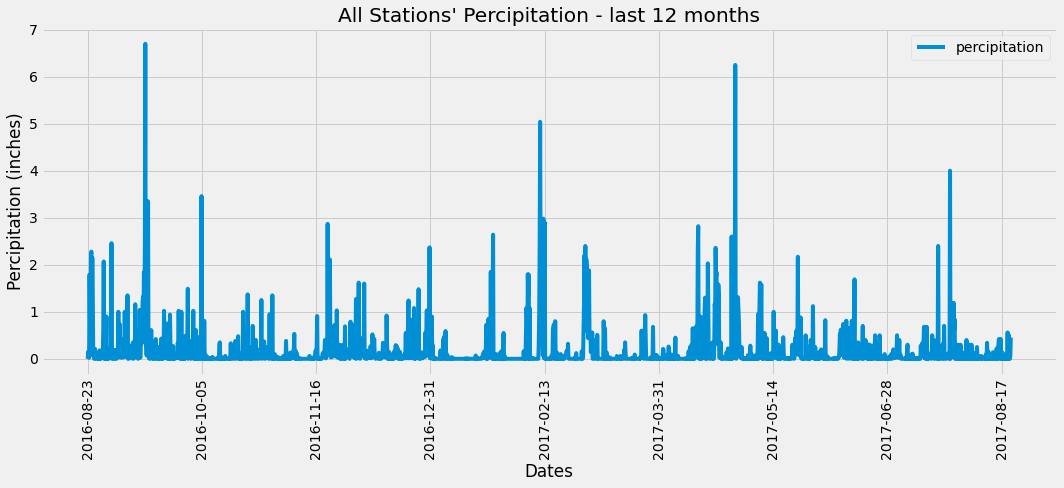

In [472]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_last12months_joined_df.plot(rot=90,figsize=(15, 7),title="All Stations' Percipitation - last 12 months")
plt.ylabel("Percipitation (inches)")
plt.xlabel("Dates")
plt.tight_layout()
plt.show()

In [420]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(prcp_last12months_joined_df.describe(include='all'))

       percipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [214]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = session.query(Station).group_by(Station.station).count()
print(number_of_stations)

9


In [311]:
station_count = session.query(Measurement.station, func.count(Station.station)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Station.station).desc()).all()
station_count

[('USC00519281', 24948),
 ('USC00519397', 24516),
 ('USC00513117', 24381),
 ('USC00519523', 24021),
 ('USC00516128', 23508),
 ('USC00514830', 19818),
 ('USC00511918', 17811),
 ('USC00517948', 12348),
 ('USC00518838', 4599)]

In [373]:
#Design a query to find the most active stations (i.e. which stations have the most rows?).
#List the stations and observation counts in descending order
station_activity_df = pd.DataFrame(station_count[:], columns=['station', 'records'])
print(station_activity_df)
most_active_station = station_activity_df.loc[0]
print(f"------------------------------------")
print(f"The most active station is {most_active_station.station} with {most_active_station.records} records")

       station  records
0  USC00519281    24948
1  USC00519397    24516
2  USC00513117    24381
3  USC00519523    24021
4  USC00516128    23508
5  USC00514830    19818
6  USC00511918    17811
7  USC00517948    12348
8  USC00518838     4599
------------------------------------
The most active station is USC00519281 with 24948 records


In [450]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station.station).scalar()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station.station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station.station).scalar()

print(f"{most_active_station.station}, the most active station has the: \
          \n HIGHEST tempurature recorded of {max_temp}  \
          \n LOWEST tempurature recorded of {min_temp}  \
          \n AVERAGE tempurature recorded = {round(avg_temp,1)}")

USC00519281, the most active station has the:           
 HIGHEST tempurature recorded of 85.0            
 LOWEST tempurature recorded of 54.0            
 AVERAGE tempurature recorded = 71.7


Text(0, 0.5, 'Frequency')

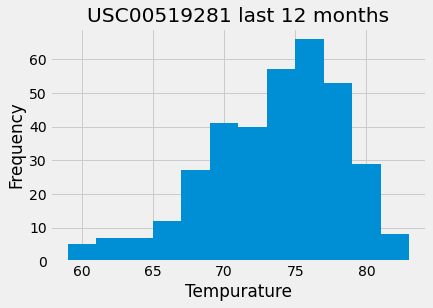

In [479]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_lst12mnths =session.query(Measurement.tobs).\
                                filter(Measurement.station == most_active_station.station).\
                                filter(Measurement.date >= last_12months_date).\
                                order_by(Measurement.date.desc()).all()

tobs_list_most_active = []

for row in most_active_station_lst12mnths:
    if type(row.tobs) == float:
        tobs_list_most_active.append(row.tobs)

tobs_list_most_active_df = pd.DataFrame({"tobs":tobs_list_most_active})
tobs_list_most_active_df["tobs"].astype(float)

hist = tobs_list_most_active_df.hist(bins=12)
plt.title("USC00519281 last 12 months")
plt.xlabel("Tempurature")
plt.ylabel("Frequency")

In [480]:
# Close the session
session.close()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
